In [199]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
import copy
from collections import Counter
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans, AffinityPropagation, AgglomerativeClustering, DBSCAN
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.metrics.cluster import fowlkes_mallows_score
from sklearn.preprocessing import normalize
from sklearn.metrics import normalized_mutual_info_score
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import normalized_mutual_info_score
from sklearn.preprocessing import StandardScaler, scale
from matplotlib.collections import LineCollection
from sklearn import manifold
from sklearn.metrics import euclidean_distances
from sklearn.decomposition import PCA
from sklearn.tree import export_graphviz
from sklearn import metrics
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import LocalOutlierFactor
import matplotlib.cm as cm
import seaborn as sns
sns.set(color_codes=True)

In [2]:
def calsse(df, clusters, centroid):
    df = pd.DataFrame(df)
    total = 0
    count = 0
    for i in range(len(clusters)):
        for p in clusters[i]:
            count+=1
            total += distance(df.iloc[p, :], centroid[i])
    # print(count)
    return total

def distance(inst1, inst2):
    try:
        inst1 = np.array(inst1)
        inst2 = np.array(inst2)

        if len(inst1) != len(inst2):
            raise NameError("Not the same dimension.")

        total = 0
        for i in range(len(inst1)):
            total += (inst1[i] - inst2[i])**2
        return total
    except ValueError:
        return 100

class Clustering():
    def __init__(self, df, ndf, labelstr, labelindex, display):
        """
        :param k: int, number of cluster
        :param df: dataframe, raw dataframe
        :param ndf: dataframe, the dataframe used in model
        :param labelstr: str, label in the dataframe
        :param labelindex: int, index of label in the dataframe
        :param display: int, 0-display all label, 1-display count label
        """
        self.df = df
        self.ndf = ndf
        self.labelindex = labelindex

        self.display = display

        self.label = copy.deepcopy(df[labelstr])
        if display == 1:
            print("Labels distribution: ")
            print(self.label.groupby(self.label).count())

            #labels = self.label.unique().tolist()

            #for i in range(len(self.label)):
            #    self.label[i] = labels.index(self.label[i])


    def KMeans_fit_predict(self, k, preproc=0, seed=32):
        """
        :param k: number of clusters
        :param preproc: 0-no preprocess, 1-normalize, 2-standardiza
        :return:
        """
        if preproc == 1:
            ndf = pd.DataFrame(normalize(self.ndf, axis=0, copy=True))
        elif preproc == 2:
            ndf = pd.DataFrame(scale(self.ndf, axis=0, copy=True))
        else:
            ndf = self.ndf

        summary = "Summary: \n"
        summary += "KMeans, k=%r \n" % k

        kmeans = KMeans(n_clusters=k, random_state=seed)
        y_pred = kmeans.fit_predict(ndf)
        sse = kmeans.inertia_

        summary += "SSE: %r \n" %sse

        clusters = dict.fromkeys([i for i in range(k)], None)
        for i in range(len(clusters)):
            clusters[i] = []
        for label in range(len(y_pred)):
            clusters[y_pred[label]].append(label)

        categories = {}
        for i in range(k):
            categories[i] = [self.df.iloc[m, self.labelindex] for m in clusters.get(i)]
        for d in range(len(categories)):
            if self.display == 0:
                summary += "Cluster %r: %r\n" %(d, ", ".join(categories[d]))
            else:
                summary +=  "Cluster %r: %r\n" % (d, Counter(categories[d]))

        cluster_center_ = {}
        for i in range(len(kmeans.cluster_centers_)):
            cluster_center_[i] = kmeans.cluster_centers_[i]

        return categories, y_pred, cluster_center_, sse, summary

    def AgglomerativeClustering_fit_predict(self, k, affinity="euclidean", linkage="complete", preproc=0, seed=32):
        if preproc == 1:
            ndf = pd.DataFrame(normalize(self.ndf, axis=0, copy=True))
        elif preproc == 2:
            ndf = pd.DataFrame(scale(self.ndf, axis=0, copy=True))
        else:
            ndf = self.ndf

        summary = "Summary: \n"
        summary += "AgglomerativeClustering, k=%r \n" % k

        ac = AgglomerativeClustering(n_clusters=k, affinity=affinity, linkage=linkage)
        y_pred = ac.fit_predict(ndf)

        clusters = dict.fromkeys([i for i in range(k)], None)
        for i in range(len(clusters)):
            clusters[i] = []
        for label in range(len(y_pred)):
            clusters[y_pred[label]].append(label)
        # calculate the center
        cluster_center_ = {}
        for i in range(k):
            cluster_center_[i] = ndf.iloc[clusters[i], :].mean().tolist()
        sse = 0
        for i in range(k):
            for iid in clusters[i]:
                sse += distance(ndf.iloc[iid, :], cluster_center_[i])

        summary += "SSE: %r \n" % sse

        categories = {}
        for i in range(k):
            categories[i] = [self.df.iloc[m, self.labelindex] for m in clusters.get(i)]
        for d in range(len(categories)):
            if self.display == 0:
                summary += "Cluster %r: %r\n" %(d, ", ".join(categories[d]))
            else:
                summary +=  "Cluster %r: %r\n" % (d, Counter(categories[d]))

        return categories, y_pred, cluster_center_, sse, summary

    def DBSCAN_fit_predict(self, eps, min_s=1, preproc=0, seed=32):
        if preproc == 1:
            ndf = pd.DataFrame(normalize(self.ndf, axis=0, copy=True))
        elif preproc == 2:
            ndf = pd.DataFrame(scale(self.ndf, axis=0, copy=True))
        else:
            ndf = self.ndf

        summary = "Summary: \n"
        summary += "DBSCAN \n"

        dbs = DBSCAN(eps=eps, min_samples=min_s, n_jobs=-1)
        y_pred = dbs.fit_predict(ndf)

        clusters = dict.fromkeys([i for i in set(y_pred)], None)
        for i in set(y_pred):
            clusters[i] = []
        for label in range(len(y_pred)):
            clusters[y_pred[label]].append(label)

        cluster_center_ = {}
        for i in set(y_pred):
            cluster_center_[i] = ndf.iloc[clusters[i], :].mean().tolist()
        sse = 0
        for i in set(y_pred):
            for iid in clusters[i]:
                sse += distance(ndf.iloc[iid, :], cluster_center_[i])

        summary += "SSE: %r \n" %sse
        
        # summary += "Std: %r \n" %

        categories = {}
        for i in set(y_pred):
            categories[i] = [self.df.iloc[m, self.labelindex] for m in clusters.get(i)]
        
        if -1 not in cluster_center_.keys():
            for d in range(len(categories)):
                if self.display == 0:
                    summary += "Cluster %r: %r\n" %(d, ", ".join(categories[d]))
                else:
                    summary +=  "Cluster %r: %r\n" % (d, Counter(categories[d]))
        else:
            for d in range(-1, len(categories) - 1):
                if self.display == 0:
                    summary += "Cluster %r: %r\n" %(d, ", ".join(categories[d]))
                else:
                    summary +=  "Cluster %r: %r\n" % (d, Counter(categories[d]))

        return categories, y_pred, cluster_center_, sse, summary

    def externalEval(self, y_pred, true_label):
        true_label = np.array(true_label)
        n_cluster = len(set(true_label))
        y_pred_modi = y_pred.copy()
        result = [[] for i in range(len(set(y_pred)))]
        for i in range(len(y_pred)):
            result[y_pred[i]].append(i)
        dict1 = dict.fromkeys([i for i in range(n_cluster)], None)
        for i in list(dict1.keys()):
            dict1[i] = []
        nummostnum = 0
        for i in range(len(result)):
            if len(true_label[result[i]]) > 0:
                mostnum = Counter(true_label[result[i]]).most_common(1)[0][0]
                nummostnum += Counter(true_label[result[i]]).most_common(1)[0][1]
                dict1[mostnum] += (result[i])
        for r in list(dict1.keys()):
            for i in dict1[r]:
                y_pred_modi[i] = r
        nmi = normalized_mutual_info_score(true_label, y_pred)
        purity = nummostnum / len(y_pred_modi)
        fowlkes_mallows = fowlkes_mallows_score(true_label, y_pred_modi)
        return nmi, purity, fowlkes_mallows

    def silhouette(self, range_n_clusters, cluster_labelss):
        X = self.ndf
        for n_cluster in range_n_clusters:
            fig, (ax1, ax2) = plt.subplots(1, 2)
            fig.set_size_inches(12, 6)

            ax1.set_xlim([-0.1, 1])
            ax1.set_ylim([0, len(X) + (n_cluster + 1) * 10])

            cluster_labels = cluster_labelss[n_cluster-2]

            # categories, cluster_labels, cluster_centers_, summary = self.kmeans_fit_predict(n_cluster, preproc)

            silhouette_avg = silhouette_score(X, cluster_labels)
            print("For n_clusters =", n_cluster,
                  "The average silhouette_score is :", silhouette_avg)

            # Compute the silhouette scores for each sample
            sample_silhouette_values = silhouette_samples(X, cluster_labels)

            y_lower = 10
            for i in range(n_cluster):
                ith_cluster_silhouette_values = \
                    sample_silhouette_values[cluster_labels == i]

                ith_cluster_silhouette_values.sort()

                size_cluster_i = ith_cluster_silhouette_values.shape[0]
                y_upper = y_lower + size_cluster_i

                color = cm.spectral(float(i) / n_cluster)
                ax1.fill_betweenx(np.arange(y_lower, y_upper),
                                  0, ith_cluster_silhouette_values,
                                  facecolor=color, edgecolor=color, alpha=0.7)

                ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

                y_lower = y_upper + 10  # 10 for the 0 samples

            ax1.set_title("The silhouette plot for the various clusters.")
            ax1.set_xlabel("The silhouette coefficient values")
            ax1.set_ylabel("Cluster label")

            # The vertical line for average silhouette score of all the values
            ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

            ax1.set_yticks([])  # Clear the yaxis labels / ticks
            ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

            # mds
            # mds
            similarities = euclidean_distances(X)
            mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=random_state,
                               dissimilarity="precomputed", n_jobs=1)
            pos = mds.fit(similarities).embedding_
            df_pos = pd.DataFrame(pos, columns=["comp1", "comp2"])
            df_pos["pred"] = cluster_labels

            for i in range(n_cluster):
                color = cm.spectral(float(i) / n_cluster)
                ax2.scatter(df_pos[df_pos["pred"] == i].iloc[:, 0], df_pos[df_pos["pred"] == i].iloc[:, 1], c=color)

            ax2.set_title("The visualization of the clustered data.")
            ax2.set_xlabel("Feature space for the 1st MDS feature")
            ax2.set_ylabel("Feature space for the 2nd MDS feature")

            plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                          "with n_clusters = %d" % n_cluster),
                         fontsize=14, fontweight='bold')
            # end mds
            plt.show()

class visualization():
    def MDSplot(self, ndf, y_pred, n_clusters, show=False):
        fig, ax = plt.subplots()
        similarities = euclidean_distances(ndf)
        mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9,
                           dissimilarity="precomputed", n_jobs=1)
        pos = mds.fit(similarities).embedding_
        df_pos = pd.DataFrame(pos, columns=["comp1", "comp2"])
        df_pos["pred"] = y_pred

        for i in range(n_clusters):
            color = cm.spectral(float(i) / n_clusters)
            ax.scatter(df_pos[df_pos["pred"] == i].iloc[:, 0], df_pos[df_pos["pred"] == i].iloc[:, 1], c=color)
        ax.set_title("The MDS visualization of the clustered data.")
        ax.set_xlabel("1st MDS feature")
        ax.set_ylabel("2nd MDS feature")
        if show:
            plt.plot()
        return ax

    def Comparingplot(self, range_n_clusters, sses, nmis, purities, fms):

        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
        fig.set_size_inches(12, 6)

        ax1.set_title("SSE")
        #ax1.set_xlabel("num of clusters")
        ax1.set_ylabel("SSE")
        ax1.plot(range_n_clusters, sses)

        ax2.set_title("NMI")
        #ax2.set_xlabel("num of clusters")
        ax2.set_ylabel("NMI")
        ax2.plot(range_n_clusters, nmis)

        ax3.set_title("Purity")
        #ax3.set_xlabel("num of clusters")
        ax3.set_ylabel("Purity")
        ax3.plot(range_n_clusters, purities)

        ax4.set_title("fowlkes_mallows score")
        #ax4.set_xlabel("num of clusters")
        ax4.set_ylabel("fowlkes_mallows score")
        ax4.plot(range_n_clusters, fms)
        plt.show()

    def visualizeData(self, kcentroid, summary):
        print(summary)
        length = len(kcentroid[0])
        ind = np.arange(length)  # the x locations for the groups
        width = 0.15  # the width of the bars
        fig, ax = plt.subplots()
        fig.set_size_inches(9, 4)
        if -1 not in kcentroid.keys():
            for k in range(len(kcentroid)):
                color = cm.spectral(float(k) / len(kcentroid))
                ax.bar(ind + k * width, kcentroid[k], width, color=color)
        else:
            for k in range(-1, len(kcentroid) - 1):
                color = cm.spectral(float(k+1) / len(kcentroid))
                ax.bar(ind + k * width, kcentroid[k], width, color=color)
        ax.set_xticks(ind + width / 2)
        if length == 7:
            ax.set_xticklabels(('Start Median', 'Mid Median', 'Percent', '10th', '25th', '75th', '90th'))
        else:
            ax.set_xticklabels(('Start Median', 'Mid Median', '10th', '25th', '75th', '90th'))

In [3]:
intru_types = {}
with open("intru_types") as f:
    for line in f:
        newline = line.split(" ")
        key = newline[0]+"."
        value = newline[1].replace("\n", "")
        intru_types[key] = value
intru_types["normal."] = "normal"

In [4]:
features = []
feature_type = []
with open("feature") as f:
    for line in f:
        features.append(line.split(":")[0])
        feature_type.append((line.split(":")[1]).replace(" ", "").replace(".\n", ""))
features.append("type")

In [5]:
kdd = pd.read_table("datasets/kddcup.data_10_percent", sep=",", index_col=False, names=features)

In [6]:
valset = pd.read_table("datasets/corrected", sep=",", index_col=False, names=features)

In [7]:
valset["type"].replace(intru_types, inplace=True)
valset = valset[valset["service"] == "http"]
valset.drop(["protocol_type", "service", "flag"], axis=1, inplace=True)

In [8]:
with open("http.arff", "w") as f:
    f.write("@relation http\n")
    for i in range(len(feature_type)):
        ftype = "numeric" if feature_type[i] == "continuous" else "nominal {}"
        f.write("@attribute "+features[i]+" "+ftype+"\n")
    f.write("@data\n")
    with open("datasets/kddcup.data_10_percent") as f1:
        for line in f1:
            line = line.replace(".\n", "\n")
            f.write(line)

In [9]:
valset.shape

(41237, 39)

In [10]:
kdd.shape

(494021, 42)

In [11]:
kdd.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,type
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


In [12]:
kdd["type"].groupby(kdd["type"]).count()

type
back.                 2203
buffer_overflow.        30
ftp_write.               8
guess_passwd.           53
imap.                   12
ipsweep.              1247
land.                   21
loadmodule.              9
multihop.                7
neptune.            107201
nmap.                  231
normal.              97278
perl.                    3
phf.                     4
pod.                   264
portsweep.            1040
rootkit.                10
satan.                1589
smurf.              280790
spy.                     2
teardrop.              979
warezclient.          1020
warezmaster.            20
Name: type, dtype: int64

In [13]:
kdd["type"].replace(intru_types, inplace=True)

In [14]:
kdd[kdd["service"] == "http"]["type"].value_counts()

normal    61886
dos        2395
probe         8
r2l           4
Name: type, dtype: int64

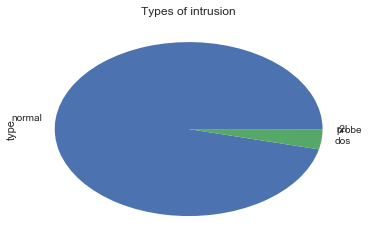

In [15]:
plt.title("Types of intrusion")
kdd[kdd["service"] == "http"]["type"].value_counts().plot("pie")

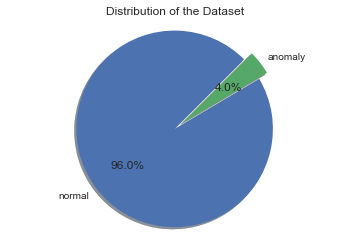

In [16]:
labels = 'normal', 'anomaly'
sizes = [96, 4]
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=45)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Distribution of the Dataset")
plt.show()

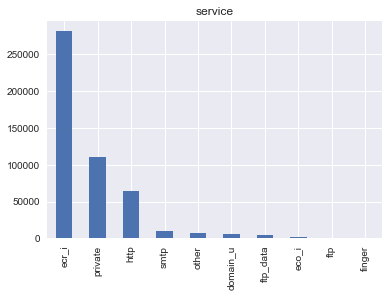

In [17]:
plt.title("service")
kdd["service"].value_counts()[:10].plot("bar")

In [18]:
http = kdd[kdd["service"] == "http"]

In [19]:
http.shape

(64293, 42)

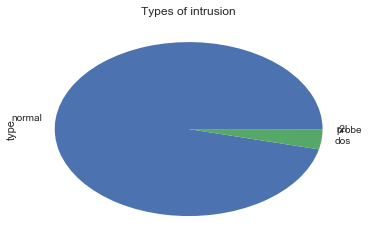

In [20]:
plt.title("Types of intrusion")
http["type"].value_counts().plot("pie")

In [21]:
http.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,type
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal


In [22]:
http["flag"].value_counts()

SF      58547
REJ      5354
S0        200
RSTR       93
RSTO       39
S1         36
S2         20
S3          4
Name: flag, dtype: int64

In [23]:
http.drop(["protocol_type", "service", "flag"], axis=1, inplace=True)

/Users/youqiao/env/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [24]:
http.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,type
0,0,181,5450,0,0,0,0,0,1,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal
1,0,239,486,0,0,0,0,0,1,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal
2,0,235,1337,0,0,0,0,0,1,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal
3,0,219,1337,0,0,0,0,0,1,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal
4,0,217,2032,0,0,0,0,0,1,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal


In [25]:
http_type = {}
http_type["normal"] = 1
http_type["dos"] = 0
http_type["probe"] = 0
http_type["r2l"] = 0

In [26]:
http_ = copy.deepcopy(http)

In [27]:
http["type"].replace(http_type, inplace=True)

/Users/youqiao/env/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3924: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [28]:
http_type = {}
http_type["normal"] = 1
http_type["dos"] = 0
http_type["probe"] = 0
http_type["r2l"] = 0
http_["type"].replace(http_type, inplace=True)

In [29]:
http_["type"].value_counts()

1    61886
0     2407
Name: type, dtype: int64

In [30]:
http_type = {}
http_type["normal"] = 1
http_type["dos"] = 0
http_type["probe"] = 0
http_type["r2l"] = 0
http_type["apache2."] = 0
http_type["saint."] = 0

In [31]:
valset["type"].groupby(valset["type"]).count()

type
apache2.      794
dos          1191
normal      39247
probe           2
r2l             2
saint.          1
Name: type, dtype: int64

In [32]:
valset["type"].replace(http_type, inplace=True)

In [33]:
valset.shape

(41237, 39)

In [34]:
kdd["type"].unique()

array(['normal', 'u2r', 'dos', 'r2l', 'probe'], dtype=object)

In [35]:
norm_dos = [0, 1]

In [36]:
httpnd = http_[http_["type"].isin(norm_dos)]

# Classification

In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics.cluster import fowlkes_mallows_score
from sklearn.preprocessing import normalize, scale
from matplotlib.collections import LineCollection
from sklearn.metrics import euclidean_distances
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score
import matplotlib.cm as cm

In [38]:
def rfmodel(dat, val, n_est=10, cri="gini", max_feat="auto", max_dep=None, seed=36):
    p = dat.shape[1]
    X_train, X_test, y_train, y_test = train_test_split(
        dat.iloc[:, :p-1], dat.iloc[:, p-1], test_size=0.25, random_state=seed, stratify=dat.iloc[:, p-1])
    X_val, y_val = val.iloc[:, :-1], val.iloc[:, -1]
    
    stat = {"accuracy": [], "precision": [], "recall": []}
    
    start = time.time()
    rf = RandomForestClassifier(n_estimators=n_est, criterion=cri, max_features=max_feat, max_depth=max_dep, n_jobs=-1)
    rf.fit(X_train, y_train)
    end = time.time()
    time_consume = end - start
    
    feat_import = pd.DataFrame({"Feature": X_train.columns, "Importance": rf.feature_importances_})\
        .sort_values("Importance", ascending=False)[:10]
    
    # predict train
    pred = rf.predict(X_train)
    accuracy = (pred == y_train).mean()
    precision = precision_score(y_train, pred, pos_label=0)
    recall = recall_score(y_train, pred, pos_label=0)
    stat["accuracy"].append(accuracy)
    stat["precision"].append(precision)
    stat["recall"].append(recall)
    
    # predict test
    pred = rf.predict(X_test)
    accuracy = (pred == y_test).mean()
    precision = precision_score(y_test, pred, pos_label=0)
    recall = recall_score(y_test, pred, pos_label=0)
    stat["accuracy"].append(accuracy)
    stat["precision"].append(precision)
    stat["recall"].append(recall)
    print(confusion_matrix(y_test, pred))
    
    # predict val
    rf.fit(dat.iloc[:, :p-1], dat.iloc[:, p-1])
    pred = rf.predict(X_val)
    accuracy = (pred == y_val).mean()
    precision = precision_score(y_val, pred, pos_label=0)
    recall = recall_score(y_val, pred, pos_label=0)
    stat["accuracy"].append(accuracy)
    stat["precision"].append(precision)
    stat["recall"].append(recall)
    
    return stat, time_consume, feat_import

def dtmodel(dat, val, cri="gini", max_feat="auto", max_dep=None, seed=36):
    p = dat.shape[1]
    X_train, X_test, y_train, y_test = train_test_split(
        dat.iloc[:, :p-1], dat.iloc[:, p-1], test_size=0.25, random_state=seed, stratify=dat.iloc[:, p-1])
    X_val, y_val = val.iloc[:, :-1], val.iloc[:, -1]
    
    stat = {"accuracy": [], "precision": [], "recall": []}
    
    start = time.time()
    rf = DecisionTreeClassifier(criterion=cri, max_features=max_feat, max_depth=max_dep)
    rf.fit(X_train, y_train)
    end = time.time()
    time_consume = end - start
    
    feat_import = pd.DataFrame({"Feature": X_train.columns, "Importance": rf.feature_importances_})\
        .sort_values("Importance", ascending=False)[:10]
    
    # predict train
    pred = rf.predict(X_train)
    accuracy = (pred == y_train).mean()
    precision = precision_score(y_train, pred, pos_label=0)
    recall = recall_score(y_train, pred, pos_label=0)
    stat["accuracy"].append(accuracy)
    stat["precision"].append(precision)
    stat["recall"].append(recall)
    
    # predict test
    pred = rf.predict(X_test)
    accuracy = (pred == y_test).mean()
    precision = precision_score(y_test, pred, pos_label=0)
    recall = recall_score(y_test, pred, pos_label=0)
    stat["accuracy"].append(accuracy)
    stat["precision"].append(precision)
    stat["recall"].append(recall)
    print(confusion_matrix(y_test, pred))
    
    # predict val
    rf.fit(dat.iloc[:, :p-1], dat.iloc[:, p-1])
    pred = rf.predict(X_val)
    accuracy = (pred == y_val).mean()
    precision = precision_score(y_val, pred, pos_label=0)
    recall = recall_score(y_val, pred, pos_label=0)
    stat["accuracy"].append(accuracy)
    stat["precision"].append(precision)
    stat["recall"].append(recall)
    
    return stat, time_consume, feat_import

In [39]:
train_recalls = []
test_recalls = []
train_precisions = []
test_precisions = []
val_recalls = []
val_precisions = []
times = []
for n in np.arange(2, 20, 2):
    stat, time_consume, feat_import = dtmodel(http, valset, max_dep=n)
    train_recalls.append(stat["recall"][0])
    train_precisions.append(stat["precision"][0])
    test_recalls.append(stat["recall"][1])
    test_precisions.append(stat["precision"][1])
    val_recalls.append(stat["recall"][2])
    val_precisions.append(stat["precision"][2])

[[  578    24]
 [   20 15452]]
[[  599     3]
 [    1 15471]]
[[  596     6]
 [    3 15469]]
[[  597     5]
 [    1 15471]]
[[  602     0]
 [    0 15472]]
[[  601     1]
 [    0 15472]]
[[  599     3]
 [    2 15470]]
[[  600     2]
 [    8 15464]]
[[  599     3]
 [    1 15471]]


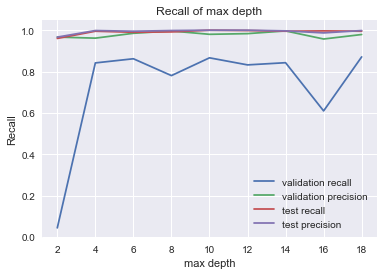

In [40]:
plt.title("Recall of max depth")
plt.xlabel("max depth")
plt.ylabel("Recall")
plt.plot(np.arange(2, 20, 2), val_recalls)
plt.plot(np.arange(2, 20, 2), val_precisions)
plt.plot(np.arange(2, 20, 2), test_recalls)
plt.plot(np.arange(2, 20, 2), test_precisions)
plt.legend(["validation recall", "validation precision", "test recall", "test precision"], loc='lower right')

[[  566    36]
 [    1 15471]]
[[  601     1]
 [    0 15472]]
[[  601     1]
 [    0 15472]]
[[  602     0]
 [    0 15472]]
[[  602     0]
 [    0 15472]]
[[  601     1]
 [    0 15472]]
[[  602     0]
 [    1 15471]]
[[  601     1]
 [    0 15472]]
[[  600     2]
 [    0 15472]]


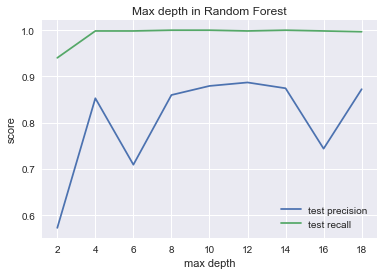

In [41]:
train_recalls = []
test_recalls = []
train_precisions = []
test_precisions = []
val_recalls = []
val_precisions = []
times = []
for n in np.arange(2, 20, 2):
    stat, time_consume, feat_import = rfmodel(http, valset, max_dep=n)
    train_recalls.append(stat["recall"][0])
    train_precisions.append(stat["precision"][0])
    test_recalls.append(stat["recall"][1])
    test_precisions.append(stat["precision"][1])
    val_recalls.append(stat["recall"][2])
    val_precisions.append(stat["precision"][2])
plt.title("Max depth in Random Forest")
plt.xlabel("max depth")
plt.ylabel("score")
plt.plot(np.arange(2, 20, 2), val_recalls)
# plt.plot(np.arange(2, 20, 2), val_precisions)
plt.plot(np.arange(2, 20, 2), test_recalls)
# plt.plot(np.arange(2, 20, 2), test_precisions)
plt.legend(["test precision", "test recall"], loc='lower right')

[[  601     1]
 [    0 15472]]
[[  602     0]
 [    0 15472]]
[[  602     0]
 [    0 15472]]
[[  601     1]
 [    0 15472]]
[[  602     0]
 [    0 15472]]
[[  602     0]
 [    0 15472]]
[[  602     0]
 [    0 15472]]
[[  602     0]
 [    0 15472]]
[[  602     0]
 [    0 15472]]
[[  601     1]
 [    0 15472]]


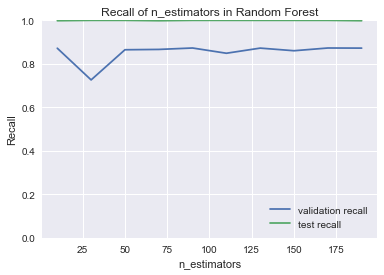

In [42]:
train_recalls = []
test_recalls = []
train_precisions = []
test_precisions = []
val_recalls = []
val_precisions = []
times = []
for n in np.arange(10, 200, 20):
    stat, time_consume, feat_import = rfmodel(http, valset, n_est=n)
    train_recalls.append(stat["recall"][0])
    train_precisions.append(stat["precision"][0])
    test_recalls.append(stat["recall"][1])
    test_precisions.append(stat["precision"][1])
    val_recalls.append(stat["recall"][2])
    val_precisions.append(stat["precision"][2])
plt.title("Recall of n_estimators in Random Forest")
plt.xlabel("n_estimators")
plt.ylabel("Recall")
plt.ylim((0,1))
plt.plot(np.arange(10, 200, 20), val_recalls)
# plt.plot(np.arange(2, 20, 2), val_precisions)
plt.plot(np.arange(10, 200, 20), test_recalls)
# plt.plot(np.arange(2, 20, 2), test_precisions)
plt.legend(["validation recall", "test recall"], loc='lower right')

In [136]:
dt = DecisionTreeClassifier()
dt.fit(http.iloc[:, :-1], http.iloc[:, -1])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [143]:
http.columns[:-1]

Index(['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment',
       'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
       'root_shell', 'su_attempted', 'num_root', 'num_file_creations',
       'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate'],
      dtype='object')

In [144]:
export_graphviz(dt, out_file='tree.dot', feature_names=http.columns[:-1])

In [43]:
stat, time_consume, feat_import = rfmodel(http, valset, n_est=50, cri="gini", max_dep=6, max_feat=7)

[[  600     2]
 [    0 15472]]


In [44]:
stat

{'accuracy': [0.99997926128704451, 0.99987557546348138, 0.99362223246113923],
 'precision': [1.0, 1.0, 0.99654974123059226],
 'recall': [0.99944598337950141, 0.99667774086378735, 0.87085427135678395]}

In [45]:
feat_import

,Feature,Importance
9,num_compromised,0.317384
1,src_bytes,0.284705
6,hot,0.159951
37,dst_host_srv_rerror_rate,0.042534
36,dst_host_rerror_rate,0.041700
2,dst_bytes,0.023855
30,dst_host_same_srv_rate,0.018523
25,same_srv_rate,0.015719
33,dst_host_srv_diff_host_rate,0.014861
26,diff_srv_rate,0.011242


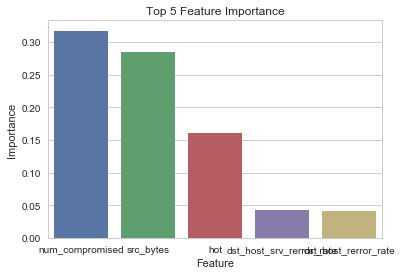

In [46]:
sns.set_style("whitegrid")
plt.title("Top 5 Feature Importance")
ax = sns.barplot(x="Feature", y="Importance", data=feat_import.iloc[:5, :])

In [47]:
stat

{'accuracy': [0.99997926128704451, 0.99987557546348138, 0.99362223246113923],
 'precision': [1.0, 1.0, 0.99654974123059226],
 'recall': [0.99944598337950141, 0.99667774086378735, 0.87085427135678395]}

[[  571    31]
 [   16 15456]]
[[  593     9]
 [    0 15472]]
[[  587    15]
 [    0 15472]]
[[  601     1]
 [    1 15471]]
[[  600     2]
 [    0 15472]]
[[  600     2]
 [    0 15472]]
[[  602     0]
 [    0 15472]]
[[  597     5]
 [    4 15468]]
[[  597     5]
 [    0 15472]]


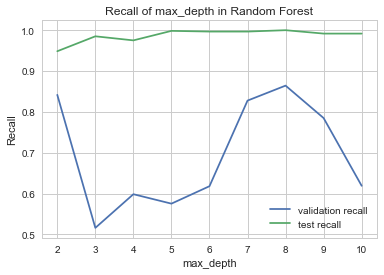

In [48]:
train_recalls = []
test_recalls = []
train_precisions = []
test_precisions = []
val_recalls = []
val_precisions = []
times = []
for n in np.arange(2, 11, 1):
    stat, time_consume, feat_import = dtmodel(http, valset, max_dep=n)
    train_recalls.append(stat["recall"][0])
    train_precisions.append(stat["precision"][0])
    test_recalls.append(stat["recall"][1])
    test_precisions.append(stat["precision"][1])
    val_recalls.append(stat["recall"][2])
    val_precisions.append(stat["precision"][2])
plt.title("Recall of max_depth in Random Forest")
plt.xlabel("max_depth")
plt.ylabel("Recall")
plt.plot(np.arange(2, 11, 1), val_recalls)
# plt.plot(np.arange(2, 20, 2), val_precisions)
plt.plot(np.arange(2, 11, 1), test_recalls)
# plt.plot(np.arange(2, 20, 2), test_precisions)
plt.legend(["validation recall", "test recall"], loc='lower right')

In [49]:
stat, time_consume, feat_import = dtmodel(http, valset, cri="gini", max_dep=8, max_feat="auto")

[[  602     0]
 [    3 15469]]


In [50]:
stat

{'accuracy': [0.99997926128704451, 0.99981336319522207, 0.97618643451269493],
 'precision': [0.99944629014396458, 0.99504132231404963, 0.96238532110091746],
 'recall': [1.0, 1.0, 0.52713567839195985]}

In [51]:
# split the dataset in training and test set:
p = http.shape[1]
X_train, X_test, y_train, y_test = train_test_split(
        http.iloc[:, :p-1], http.iloc[:, p-1], test_size=0.25, stratify=http.iloc[:, p-1])

# TASK: Build a vectorizer / classifier pipeline that filters out tokens
# that are too rare or too frequent
pipeline = Pipeline([
        ('rf', RandomForestClassifier(n_jobs=-1)),
    ])

# TASK: Build a grid search to find out whether unigrams or bigrams are
# more useful.
# Fit the pipeline on the training set using grid search for the parameters
parameters = {
        'rf__n_estimators': [10, 30, 50],
        'rf__criterion': ["gini", "entropy"],
        'rf__max_features': ["auto", "log2", None],
        'rf__max_depth': [1, 2, 4, 8, 16, 32],
    }
grid_search = GridSearchCV(pipeline, parameters, scoring="recall", n_jobs=-1)
grid_search.fit(X_train, y_train)

# TASK: print the mean and std for each candidate along with the parameter
# settings for all the candidates explored by grid search.
# n_candidates = len(grid_search.cv_results_['params'])
# for i in range(n_candidates):
#     print(i, 'params - %s; mean - %0.2f; std - %0.2f'
#                  % (grid_search.cv_results_['params'][i],
#                     grid_search.cv_results_['mean_test_score'][i],
#                     grid_search.cv_results_['std_test_score'][i]))

# TASK: Predict the outcome on the testing set and store it in a variable
# named y_predicted
y_predicted = grid_search.predict(X_test)

# Print the classification report
print(metrics.classification_report(y_test, y_predicted))

# Print and plot the confusion matrix
cm = metrics.confusion_matrix(y_test, y_predicted)
print(cm)

             precision    recall  f1-score   support

          0       0.00      0.00      0.00       602
          1       0.96      1.00      0.98     15472

avg / total       0.93      0.96      0.94     16074

[[    0   602]
 [    0 15472]]


/Users/youqiao/env/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [52]:
grid_search.best_estimator_

Pipeline(memory=None,
     steps=[('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=1, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

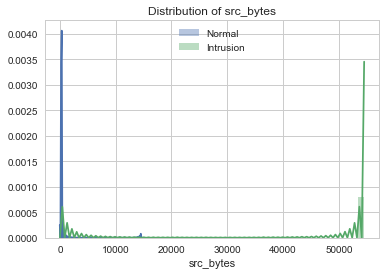

In [53]:
plt.title('Distribution of src_bytes')
sns.distplot(http[http["type"] == 1]["src_bytes"])
sns.distplot(http[http["type"] == 0]["src_bytes"])
plt.legend(["Normal", "Intrusion"], loc='upper center')
plt.show()

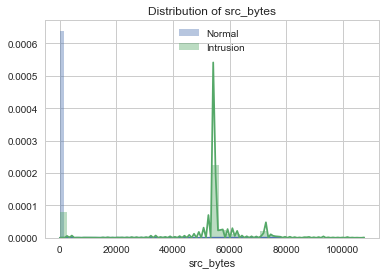

In [54]:
plt.title('Distribution of src_bytes')
sns.distplot(valset[valset["type"] == 1]["src_bytes"])
sns.distplot(valset[valset["type"] == 0]["src_bytes"])
plt.legend(["Normal", "Intrusion"], loc='upper center')
plt.show()

In [178]:
from sklearn.ensemble import IsolationForest
def isfmodel(dat, val, n_est=100, max_samp="auto", contam=0.1, max_feat=1.0, seed=36):
    stat = {"accuracy": [], "precision": [], "recall": []}
    X = dat.iloc[:, :-1]
    y = dat.iloc[:, -1]
    start = time.time()
    isf = IsolationForest(n_estimators=n_est, max_samples=max_samp, contamination=contam, max_features=max_feat, n_jobs=-1)
    isf.fit(X)
    end = time.time()
    time_consume = end - start
    # predict train
    pred = isf.predict(X)
    np.place(pred, pred==-1, 0)
    accuracy = (pred == y).mean()
    precision = precision_score(y, pred, pos_label=0)
    recall = recall_score(y, pred, pos_label=0)
    #print("Test")
    #print(confusion_matrix(y, pred))
    stat["accuracy"].append(accuracy)
    stat["precision"].append(precision)
    stat["recall"].append(recall)

    # predict val
    X_val = val.iloc[:, :-1]
    y_val = val.iloc[:, -1]
    pred = isf.predict(X_val)
    np.place(pred, pred==-1, 0)
    accuracy = (pred == y_val).mean()
    precision = precision_score(y_val, pred, pos_label=0)
    recall = recall_score(y_val, pred, pos_label=0)
    stat["accuracy"].append(accuracy)
    stat["precision"].append(precision)
    stat["recall"].append(recall)
    #print("Val")
    #print(confusion_matrix(y_val, pred))
    return stat, time_consume

In [165]:
stat, time_consume = isfmodel(http, valset, contam=0.08, n_est=100)

Test
[[ 2027   380]
 [ 3123 58763]]
Val
[[ 1987     3]
 [ 1312 37935]]


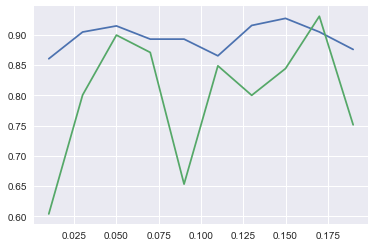

In [180]:
pres = []
recs = []
for i in np.arange(0.01, 0.2, 0.02):
    stat, time_consume = isfmodel(http, valset, contam=0.08, n_est=100)
    pres.append(stat["precision"][1])
    recs.append(stat["recall"][1])
plt.plot(np.arange(0.01, 0.2, 0.02), pres)
plt.plot(np.arange(0.01, 0.2, 0.02), recs)

In [176]:
pres

[0.29743390357698291,
 0.31078717201166178,
 0.3666407465007776,
 0.41552423247731224,
 0.35886469673405907,
 0.20820373250388802,
 0.40793036750483558,
 0.27954898911353032,
 0.29821150855365475,
 0.37823234272481665]

In [177]:
recs

[0.63564603240548401,
 0.66431242210220187,
 0.78354798504362277,
 0.894058994599086,
 0.76692978811798918,
 0.44495222268383883,
 0.87619443290402987,
 0.59742417947652682,
 0.63730785209804741,
 0.81429164935604492]

0.991275446614
0.309227579057


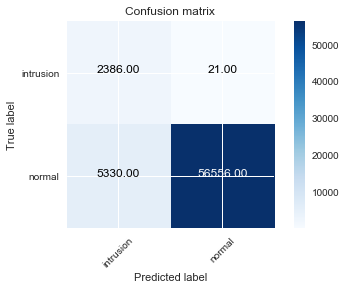

In [299]:
isf = IsolationForest(n_estimators=1000, contamination=0.12, n_jobs=-1)
isf.fit(http.iloc[:, :-1])
y_pred_train = isf.predict(http.iloc[:, :-1])
np.place(y_pred_train, y_pred_train==-1, 0)
print(recall_score(http.iloc[:, -1], y_pred_train, pos_label=0))
print(precision_score(http.iloc[:, -1], y_pred_train, pos_label=0))
plot_confusion_matrix(confusion_matrix(http.iloc[:, -1], y_pred_train), ["intrusion", "normal"])

# Clustering

In [261]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
import itertools
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [128]:
httpsp = http.sample(frac=0.01, random_state=33)

In [129]:
httpsp.reset_index(inplace=True)

[]

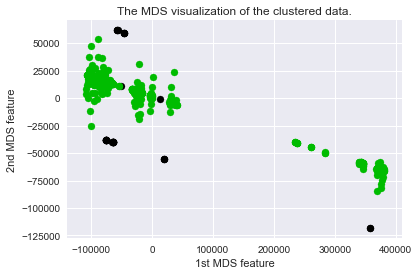

In [130]:
fig, ax = plt.subplots()
similarities = euclidean_distances(httpsp.iloc[:, :-1])

mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9,
                   dissimilarity="precomputed", n_jobs=1)
pos = mds.fit(similarities).embedding_
df_pos = pd.DataFrame(pos, columns=["comp1", "comp2"])
df_pos["pred"] = httpsp.iloc[:, -1]

for i in range(2):
    color = cm.spectral(float(i) / 2)
    ax.scatter(df_pos[df_pos["pred"] == i].iloc[:, 0], df_pos[df_pos["pred"] == i].iloc[:, 1], c=color)
ax.set_title("The MDS visualization of the clustered data.")
ax.set_xlabel("1st MDS feature")
ax.set_ylabel("2nd MDS feature")
plt.plot()

In [132]:
# PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
httppca = pca.fit_transform(http.iloc[:, :-1])

In [133]:
print(pca.explained_variance_ratio_)

[  3.60787441e+08   9.63534115e+07   2.64188884e+04   1.11686903e+04
   1.79444061e+03]


In [66]:
httpc = http.iloc[:, :-1]

In [67]:
kmeans = KMeans(n_clusters=2, random_state=12)
y_pred = kmeans.fit_predict(httpc)

In [68]:
(y_pred == 3).sum()

0

In [69]:
cluster = Clustering(http, http.iloc[:, :-1], "type", len(http.columns) - 1, 1)

Labels distribution: 
type
0     2407
1    61886
Name: type, dtype: int64


In [263]:
start = time.time()
categories, y_pred, cluster_centers_, sse, summary = cluster.KMeans_fit_predict(4, preproc=0)
end = time.time()
print(end - start)
print(summary)

1.5209441184997559
Summary: 
KMeans, k=4 
SSE: 4671031349360.1279 
Cluster 0: Counter({1: 61822, 0: 217})
Cluster 1: Counter({1: 1})
Cluster 2: Counter({0: 2190})
Cluster 3: Counter({1: 63})



In [90]:
from sklearn.metrics import homogeneity_score
range_n_clusters = [2,3,4,5,6,7]
cluster_labelss = []
sses = []
nmis = []
purities = []
fms = []
hs = []
usedtime = []
for k in range_n_clusters:
    start = time.time()
    categories, y_pred, cluster_centers_, sse, summary = cluster.KMeans_fit_predict(k, preproc=2)
    end = time.time()
    usedtime.append(end - start)
    cluster_labelss.append(y_pred)
    sses.append(sse)
    nmi, purity, fowlkes_mallows = cluster.externalEval(y_pred, cluster.label)
    nmis.append(nmi)
    hs.append(homogeneity_score(y_pred, cluster.label))
    purities.append(purity)
    fms.append(fowlkes_mallows)
# clustering.silhouette(range_n_clusters, cluster_labelss)

/Users/youqiao/env/anaconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:859: RuntimeWarning: overflow encountered in long_scalars
  return tk / np.sqrt(pk * qk) if tk != 0. else 0.
/Users/youqiao/env/anaconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:859: RuntimeWarning: invalid value encountered in sqrt
  return tk / np.sqrt(pk * qk) if tk != 0. else 0.


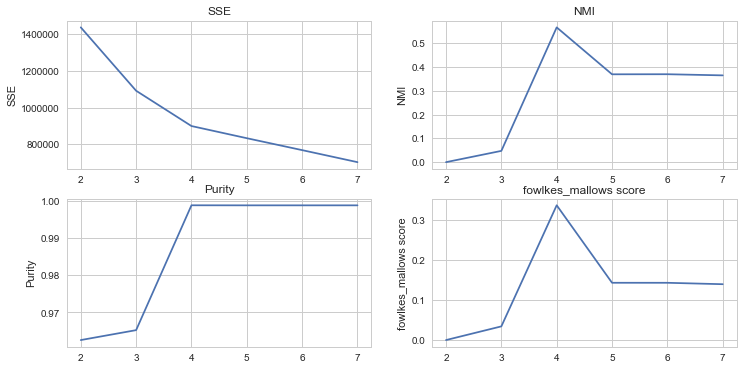

In [91]:
visualization().Comparingplot(range_n_clusters, sses, nmis, purities, hs)

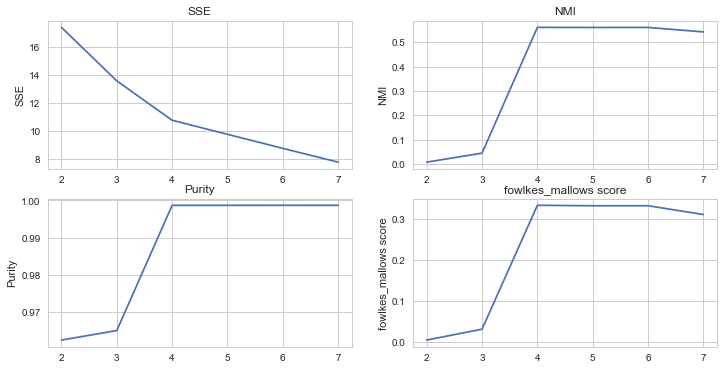

In [89]:
visualization().Comparingplot(range_n_clusters, sses, nmis, purities, hs)

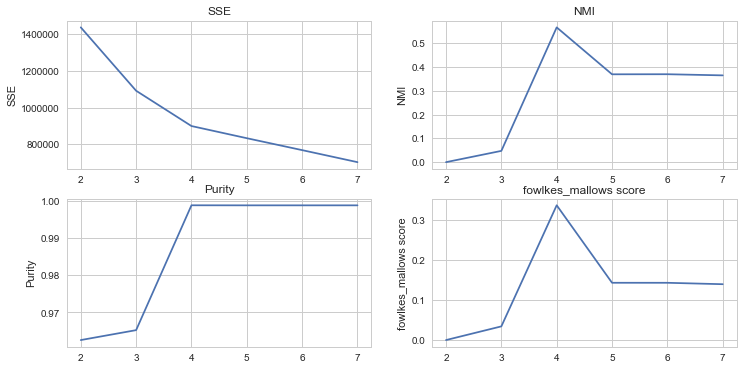

In [87]:
visualization().Comparingplot(range_n_clusters, sses, nmis, purities, hs)

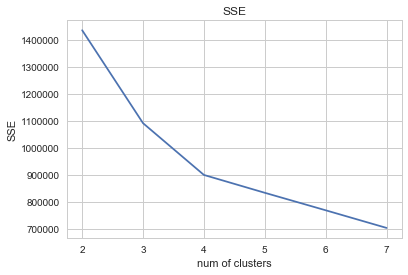

In [73]:
plt.title("SSE")
plt.xlabel("num of clusters")
plt.ylabel("SSE")
plt.plot(range_n_clusters, sses)

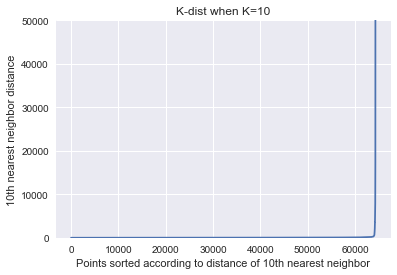

In [222]:
k = 10
nbrs = NearestNeighbors(n_neighbors=k).fit(http.iloc[:, :-1])
distances, indices = nbrs.kneighbors(http.iloc[:, :-1])
dist = distances[:, k-1]
dist.sort()
plt.title("K-dist when K=%r" % k)
plt.xlabel("Points sorted according to distance of %rth nearest neighbor" %k)
plt.ylabel("%rth nearest neighbor distance" %k)
plt.ylim((0, 50000))
plt.plot(np.arange(0, len(dist)), dist)

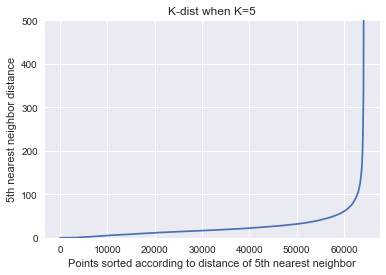

In [220]:
plt.title("K-dist when K=%r" % k)
plt.xlabel("Points sorted according to distance of %rth nearest neighbor" %k)
plt.ylabel("%rth nearest neighbor distance" %k)
plt.ylim((0, 500))
plt.plot(np.arange(0, len(dist)), dist)

In [76]:
dist.shape

(64293,)

In [227]:
start = time.time()
categories, y_pred, cluster_centers_, sse, summary = \
cluster.DBSCAN_fit_predict(eps=80, min_s=10, preproc=0)
end = time.time()
print(end - start)
# visualization().visualizeData(cluster_centers_, summary)

34.60811185836792


In [228]:
print(summary)

Summary: 
DBSCAN 
SSE: 20656859360413.941 
Cluster -1: Counter({1: 2796, 0: 70})
Cluster 0: Counter({1: 52321})
Cluster 1: Counter({1: 24})
Cluster 2: Counter({1: 35})
Cluster 3: Counter({1: 29})
Cluster 4: Counter({1: 67})
Cluster 5: Counter({1: 23})
Cluster 6: Counter({1: 20})
Cluster 7: Counter({1: 55})
Cluster 8: Counter({1: 31})
Cluster 9: Counter({1: 18})
Cluster 10: Counter({1: 26})
Cluster 11: Counter({1: 63})
Cluster 12: Counter({1: 11})
Cluster 13: Counter({1: 21})
Cluster 14: Counter({1: 14})
Cluster 15: Counter({1: 21})
Cluster 16: Counter({1: 21})
Cluster 17: Counter({1: 26})
Cluster 18: Counter({1: 14})
Cluster 19: Counter({1: 49})
Cluster 20: Counter({1: 21})
Cluster 21: Counter({1: 25})
Cluster 22: Counter({1: 26})
Cluster 23: Counter({1: 13})
Cluster 24: Counter({1: 34})
Cluster 25: Counter({1: 21})
Cluster 26: Counter({1: 17})
Cluster 27: Counter({1: 24})
Cluster 28: Counter({1: 76})
Cluster 29: Counter({1: 16})
Cluster 30: Counter({1: 54})
Cluster 31: Counter({1: 25}

In [225]:
categories, y_pred, cluster_centers_, sse, summary = \
cluster.DBSCAN_fit_predict(eps=10000, min_s=10, preproc=0)
# visualization().visualizeData(cluster_centers_, summary)

In [226]:
print(summary)

Summary: 
DBSCAN 
SSE: 16494072419072.641 
Cluster -1: Counter({1: 18, 0: 1})
Cluster 0: Counter({1: 61840, 0: 203})
Cluster 1: Counter({1: 12})
Cluster 2: Counter({1: 14})
Cluster 3: Counter({0: 2203, 1: 2})



In [231]:
httpsc = scale(http.iloc[:, :-1], axis=0, copy=True)

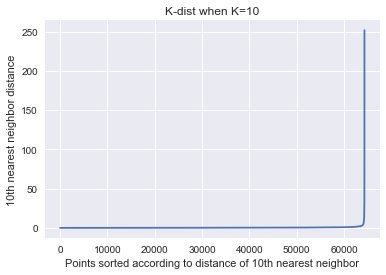

In [232]:
k = 10
nbrs = NearestNeighbors(n_neighbors=k).fit(httpsc)
distances, indices = nbrs.kneighbors(httpsc)
dist = distances[:, k-1]
dist.sort()
plt.title("K-dist when K=%r" % k)
plt.xlabel("Points sorted according to distance of %rth nearest neighbor" %k)
plt.ylabel("%rth nearest neighbor distance" %k)
plt.plot(np.arange(0, len(dist)), dist)

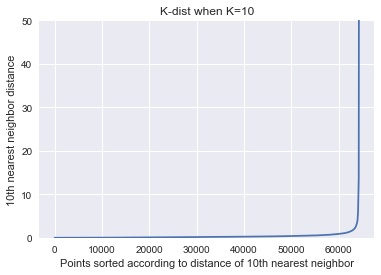

In [233]:
plt.title("K-dist when K=%r" % k)
plt.xlabel("Points sorted according to distance of %rth nearest neighbor" %k)
plt.ylabel("%rth nearest neighbor distance" %k)
plt.ylim((0, 50))
plt.plot(np.arange(0, len(dist)), dist)

In [234]:
categories, y_pred, cluster_centers_, sse, summary = \
cluster.DBSCAN_fit_predict(eps=5, min_s=10, preproc=2)
# visualization().visualizeData(cluster_centers_, summary)

In [235]:
print(summary)

Summary: 
DBSCAN 
SSE: 1127287.2268037486 
Cluster -1: Counter({1: 111, 0: 60})
Cluster 0: Counter({1: 61446, 0: 69})
Cluster 1: Counter({1: 13})
Cluster 2: Counter({1: 315})
Cluster 3: Counter({0: 2116, 1: 1})
Cluster 4: Counter({0: 139})
Cluster 5: Counter({0: 23})



In [256]:
lof = LocalOutlierFactor(n_neighbors=5000, metric="euclidean", contamination=0.05, n_jobs=-1)
y_pred = lof.fit_predict(http.iloc[:, :-1])
np.place(y_pred, y_pred==-1, 0)
print(Counter(y_pred))
print(confusion_matrix(http.iloc[:, -1], y_pred))
print(recall_score(http.iloc[:, -1], y_pred, pos_label=0))
print(precision_score(http.iloc[:, -1], y_pred, pos_label=0))

Counter({1: 61078, 0: 3215})
[[ 2205   202]
 [ 1010 60876]]
0.916078105526
0.685847589425


In [302]:
httpnm = normalize(http.iloc[:, :-1], axis=0, copy=True)

In [303]:
start = time.time()
lof = LocalOutlierFactor(n_neighbors=5000, metric="euclidean", contamination=0.05, n_jobs=-1)
y_pred = lof.fit_predict(httpnm)
end = time.time()
print(end - start)
np.place(y_pred, y_pred==-1, 0)
print(Counter(y_pred))
print(confusion_matrix(http.iloc[:, -1], y_pred))
print(recall_score(http.iloc[:, -1], y_pred, pos_label=0))
print(precision_score(http.iloc[:, -1], y_pred, pos_label=0))

150.29407382011414
Counter({1: 61078, 0: 3215})
[[ 2231   176]
 [  984 60902]]
0.926879933527
0.693934681182


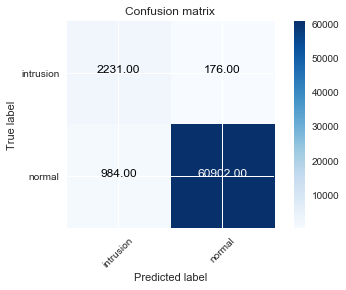

In [304]:
plot_confusion_matrix(confusion_matrix(http.iloc[:, -1], y_pred), ["intrusion", "normal"])

In [244]:
range_n_clusters = [2,3,4,5,6,7]
sses = []
httpn = http[http["type"] == 1]
for k in range_n_clusters:
    km = KMeans(n_clusters=k)
    y_pred = km.fit_predict(httpn)
    sses.append(km.inertia_)
# clustering.silhouette(range_n_clusters, cluster_labelss)

In [252]:
km = KMeans(n_clusters=5)
y_pred = km.fit_predict(httpn)
Counter(y_pred)

Counter({0: 58106, 1: 1, 2: 3695, 3: 79, 4: 5})

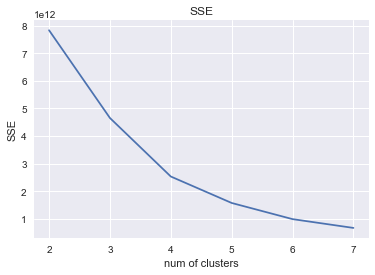

In [245]:
plt.title("SSE")
plt.xlabel("num of clusters")
plt.ylabel("SSE")
plt.plot(range_n_clusters, sses)